UVICAI RL Car Racer environment <br>
July 2024

This notebook is solving some of the installation challenges and laying the foundations for porting what we learned from CartPole over. Comments contain ideas about how to move forward with this environment.

The dependancies are a pain but has worked for Colab. If you have challenges with a local installation, please keep notes about what you experienced and how you fixed it.



### Install dependancies
Takes a moment

In [10]:
# The "-q" flag makes installation quiet(er)

%pip install gymnasium -q
#!apt-get install build-essential -q
#!apt-get install swig -q
#!apt-get install python-box2d -q
%pip install gym[box2d] -q
%pip install matplotlib
%pip install tqdm
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-2.4.0-cp310-cp310-manylinux1_x86_64.whl (797.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 12.2 MB/s eta 0:00:0000:0100:01
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl (664.8 MB)
  Using cached nvidia_nvtx

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import gym
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm

# NN framework
#import tensorflow as tf
import torch

Below are some environment specific initializations

In [2]:

# create a human-readable dictionary for actions
action_dict = dict(zip(['null','right','left','gas','brake'], np.arange(5)))
action_dict

def skip_zoom(env):
    # at initialization the camera starts very zoomed out (maybe to see the whole track?)
    # skip the zoom at initialization by waiting for 2 seconds (100 frames)
    env.reset()
    for i in range(100):
        obs, _, _, _ = env.step(0)

    # remove the penalty while zooming in
    env.reward = 0.0
    env.prev_reward = 0.0
    return obs


''' ------------------ '''
prob_actions = np.array([0.1,0.3,0.3,0.6,0.05])
prob_actions /= prob_actions.sum()

def get_random_action() -> int:
  # instead of env.action_space.sample()
  return np.random.choice(5, p = prob_actions) # env.action_space.sample()


## Preprocess

preprocessing of states
 - split by colour?
 - add a channel of edges using an openCV tool


In [3]:

def preprocess(observation):
    # break the observation by channel if the pixel value is beyond some threshold
    red_channel = observation[:,:,0] > 100
    green_channel = observation[:,:,1] < 50
    blue_channel = observation[:,:,2] > 20

    # use other preprocessing tools?
    #edge_channel = some_scipy_function(observation)

    # merge
    processed_observation = np.array([red_channel, green_channel, blue_channel])

    return processed_observation


## Memory system

memory system
 - what to store and how to do so
 - prioritize some memories (weight the model to be more informed by memories that are closer to the center of the track?)


In [ ]:
class memory_system():
    def __init__(self, args):
        self.memory_arguments = args

    def memory_store(self):
        pass

    def pull_memories(self, n_samples):
        pass


## agent / model

model architecture
 - split the visual section from the "heads up display"?
 - convolutional blocks? residual blocks?
 - coarse pretrain the weights with an autoencoder?


In [ ]:
def build_my_model() -> tf.keras.Model:
    ''' ------ this is a bad placeholder model -----'''

    xin = tf.keras.layers.Input((96,96,3))
    x1 = tf.keras.layers.Conv2D(8,(3,3),activation='swish', padding='same')(xin)
    x1 = tf.keras.layers.Flatten()(x1)
    x0 = tf.keras.layers.Dense(64,activation='swish')(x0)
    xout = tf.keras.layers.Dense(5,activation='linear')(x0)

    return tf.keras.models.Model(xin,xout)

In [ ]:
class DQNAgent():
    ''' ---- needs significant work. roughly written for TF, adapt as needed ---- '''
    def __init__(self,obs_space,bs,model_copy_interval = 3, mem_capacity = 10000):
        self.observation_space = (96,96,3) # number of features for observations
        self.action_space = 5
        self.gamma = tf.cast(0.9, tf.float32) # discount factor

        # model things
        self.model = build_my_model()
        self.model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-4))
        self.anchor_model = build_my_model()
        self.copy_weights()
        self.model_copy_interval = model_copy_interval

        # memory things
        self.bs = bs
        self.mem_pool = '???'

    def copy_model_weights(self) -> None:
        self.anchor_model.set_weights(self.model.get_weights()) # for TF
        self.anchor_model.load_state_dict(self.model.state_dict()) # for PyTorch

    def select_action(self,state) -> int:
        ''' ---- get the argmax of the agent to select best action --- '''
        # assumes epsilon is dealt with elsewhere
        _f = preprocess(state)
        return tf.math.argmax(self.model(_f)[0])

    def mem_store(self, memory_tuple):
        # store raw state, or store processed state?
        pass

    def memory_select(self):
        ''' --- select a random subset of memories to train on --- '''
        pass

    def learn(self) -> float:
        # pull memories

        # calculate current estimates

        # calculate better estimates

        # update model
        hist = self.model.fit(_state,
                              adjusted_q_values,
                              verbose=0,epochs=3)

        return hist.history['loss'][0]


## Reward Modelling

reward modelling
 - penalty for car being off the track
 - bonus for speed
 - bonus for being towards the center
 - (these help guide the model towards desired behaviour)


In [ ]:
def reward_model(state, action, other) -> float:
    some_bonus_reward = 0.0

    # do some stuff

    return some_bonus_reward

## Training Loop

Pull it all together
 - when to reset the model (the environment is overly permissive)
 - when to train, which method (TD or output adjust)
 - what metrics to track

In [ ]:

def burn_in_memories(agent, env, n_memories) -> None:
    # observe some near-initialization memories at start of training
    pass


def memory_filter(agent, action, state, other_args) -> bool:
    # not all memories are worth saving, this function decides whether to
    # continue the episode based on the quality of the state

    # if the state has some definable quality (eg, car on track)
    if state > quality:
        return True

    # use the agent's model to decide whether to continue exploring?
    if agent.model.predict(state).max() > 0:
        return True

    return False

In [ ]:

def get_fit_decay(n_episodes, ep_min, ep_start):
    return np.round(np.exp((np.log(ep_min) - np.log(ep_start)) / n_episodes), 6)

def exponential_schedule(start, stop, steps):
    decay_factor = get_fit_decay(n_episodes = steps, ep_min = stop, ep_start = start)

    schedule = np.zeros(steps)
    schedule[0] = start
    for i in range(1, steps):
        schedule[i] = schedule[i-1] * decay_factor
    return schedule

In [9]:
env = gym.make("CarRacing-v2",
               continuous=False, render_mode = 'human')


In [9]:
# initialize agent
agent = DQNAgent(your_favourite_arguments)

# initialize environment
env = gym.make("CarRacing-v2",
               continuous=False, render_mode = None)

# burn in memories
burn_in(agent = agent,
        env = env,
        n_memories = 5000)


NameError: name 'DQNAgent' is not defined

In [ ]:

# Global Constants, change these
N_EPISODES = 100

# track reward trajectories as function of time
rewards = []
losses = []
eps_min = 0.05

# epsilon schedule
decay_schedule = exponential_schedule(start = 0.8,
                                      stop = eps_min,
                                      steps = N_EPISODES) # exp decay


In [ ]:
# Make the main loop.
for _episode, _epsilon in zip(tqdm(range(N_EPISODES)), decay_schedule):

    # initialize episode
    episode_total_rewards = 0
    obs = skip_zoom(env)
    terminated = False

    # loop through episodes
    while not terminated:
        # select action or explore
        if np.random.rand() > _epsilon:
            action = agent.select_action(obs).numpy()
        else:
            action = get_random_action()

        # Take the action and observe the result
        new_obs, reward, terminated, info = env.step(action)
        reward_bonus = reward_model(state, action, other)

        # Accumulate the reward as a metric
        episode_total_rewards += reward

        # Memory quality check
        if memory_filter(agent, state, action, other_args):
            terminated = True # user-terminated

        else:
            # Store our memory


            # prepare for next loop
            obs = new_obs

    # learn
    loss = agent.learn()
    losses.append(loss)

    # copy weights to anchor model
    agent.learn_counter += 1
    if agent.learn_counter > agent.model_copy_interval:
        agent.learn_counter = 0
        agent.copy_weights()

    # log episode metrics
    rewards.append(episode_total_rewards)

env.close()

  0%|          | 0/100 [00:00<?, ?it/s]

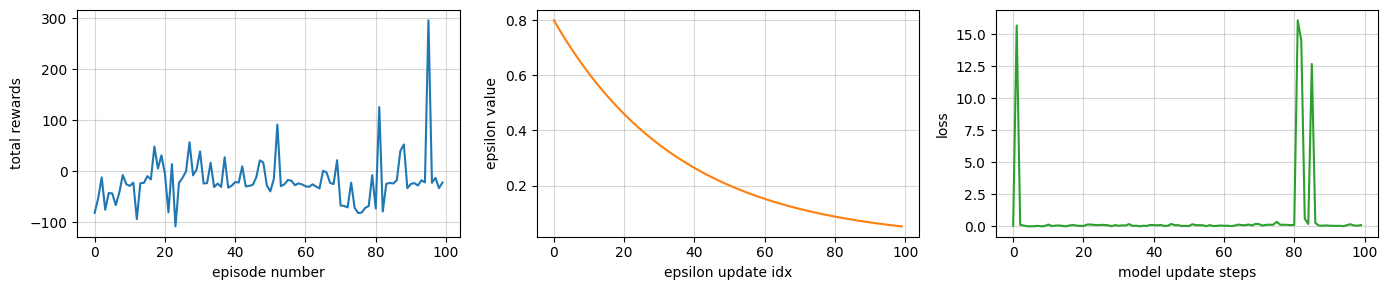

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(14,3))

ax[0].plot(rewards)
ax[0].set_ylabel('total rewards')
ax[0].set_xlabel('episode number')
ax[0].grid(alpha=0.5)

ax[1].plot(decay_schedule,c='tab:orange')
ax[1].set_ylabel('epsilon value')
ax[1].set_xlabel('epsilon update idx')
ax[1].grid(alpha=0.5)
ax[1].set_xlim(ax[0].get_xlim())

ax[2].plot(losses,c='tab:green')
ax[2].set_ylabel('loss')
ax[2].set_xlabel('model update steps')
ax[2].grid(alpha=0.5)

plt.tight_layout()

## Visualizations

 - tools to filter memories by some property and how to look at them (individually and as a collection). (t-SNE embedding?)
 - Be able to identify when the model is uncertain about a memory
 - be able to inspect which action is taken with what proportion




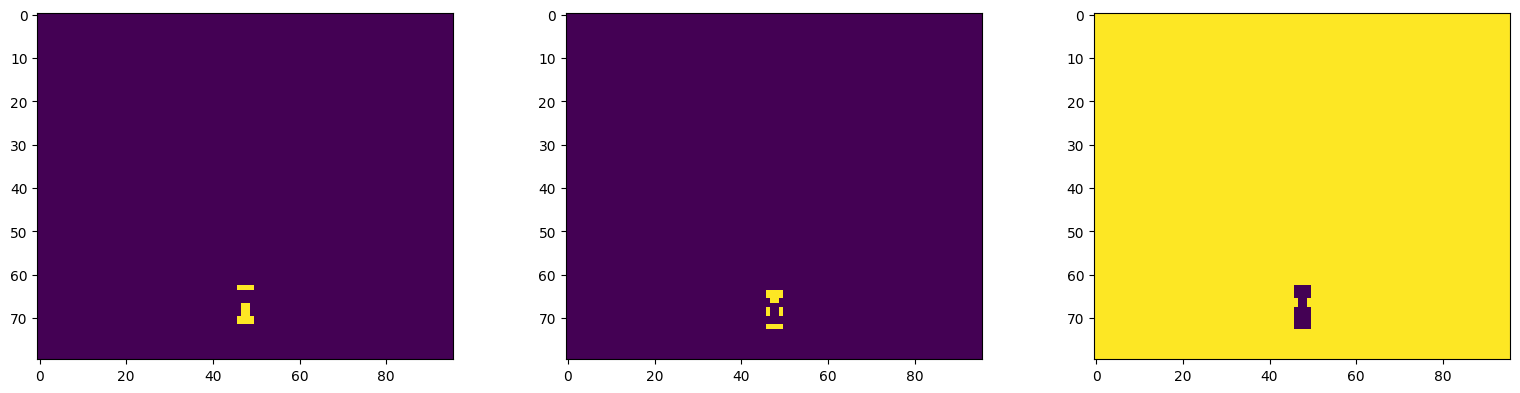

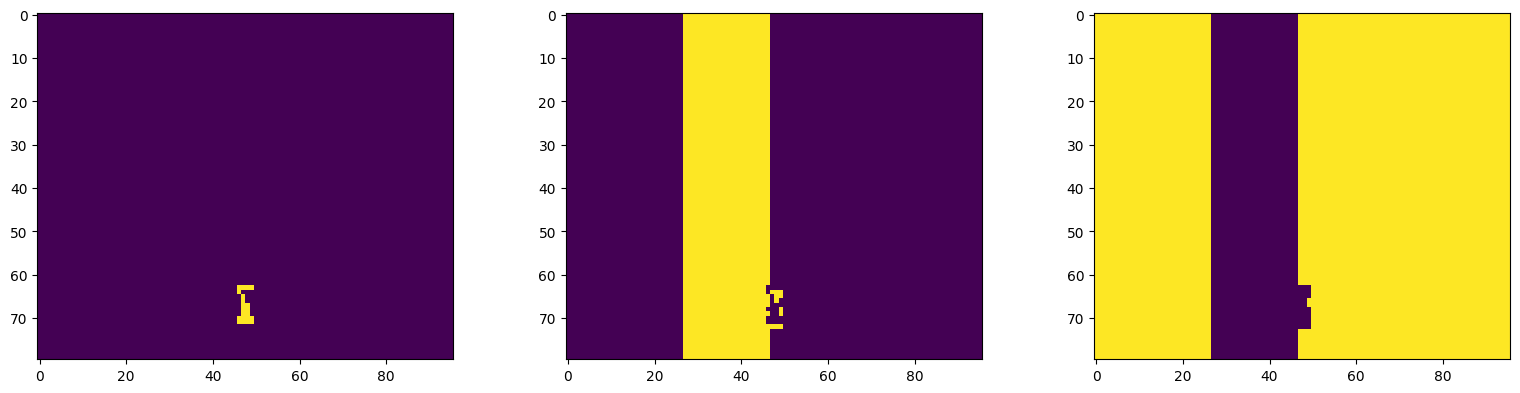

In [ ]:
memory_observation = select_from_memories(from_where_ever)

# rough visualization
fig,ax=plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    ax[i].imshow(memory_observation[31][:,:,i])
plt.tight_layout()

fig,ax=plt.subplots(1,3,figsize=(16,4))
for i in range(3):
    ax[i].imshow(memory_observation[45][:,:,i])
plt.tight_layout()
